In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [14]:
!pwd
%cd /content/drive/MyDrive/AI/MachineLearning/Potato-Leaf-Disease-Classification/training/
!pwd

/content
/content/drive/MyDrive/AI/MachineLearning/Potato-Leaf-Disease-Classification/training
/content/drive/MyDrive/AI/MachineLearning/Potato-Leaf-Disease-Classification/training


In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [16]:
classnames = dataset.class_names
classnames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

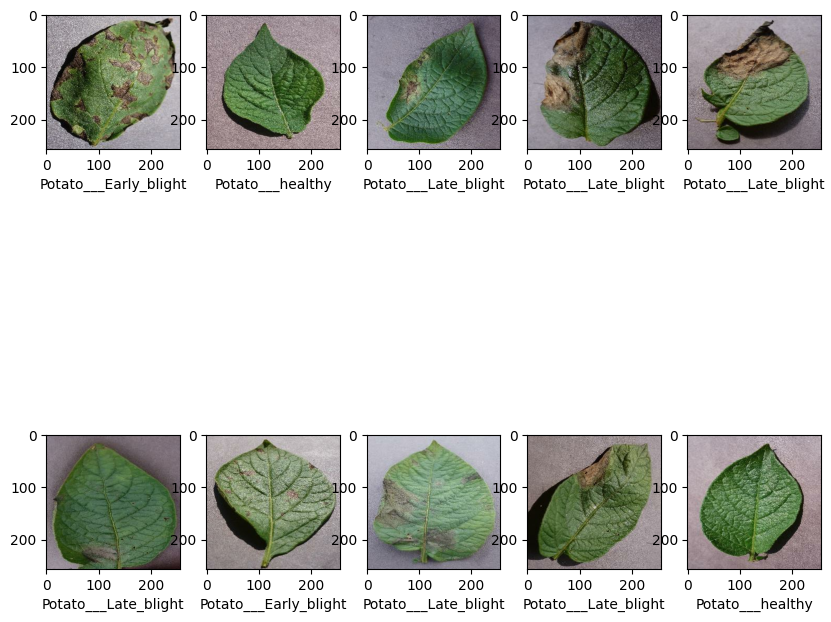

In [23]:
#exploring the data
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(10):
    #print(image_batch.shape)
    #print(label_batch.numpy())
    ax = plt.subplot(2,5,i+1)
    plt.xlabel(classnames[label_batch[i]])
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    #plt.axis("off")

In [24]:
#I need to divide the size of train and test sets as 80% and 20%(10% validation & 10% test)
train_size = 0.8
train_size * len(dataset)

54.400000000000006

In [25]:
train_set = dataset.take(54)
len(train_set)

54

In [26]:
test_set = dataset.skip(54) #skips first 54 batches, each batch is of size 32
len(test_set)

14

In [27]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [ ]:
#will take 6 samples of valid set
val_set = test_set.take(6)
test_set = test_set.skip(6)

In [29]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)
  train_size = (int)(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_set = dataset.take(train_size)
  val_set = dataset.skip(train_size).take(val_size)
  test_set = dataset.skip(train_size).skip(val_size)
  return train_set,val_set,test_set

In [31]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))


54
6
8


In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
#normalizing the values
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [33]:
#normalizing the values
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])